In [1]:

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
img_rows = 28
img_cols = 28
channels = 1

# Input shape
img_shape = (img_rows, img_cols, channels)

# Noise Vector
z_dim = 100

In [0]:
def build_generator(z_dim):
  model = Sequential()
  
  # reshape to 7x7x256 using a dense layer
  model.add(Dense(256 * 7 * 7, input_dim=z_dim))
  model.add(Reshape((7, 7, 256)))
  
  # transposed conv operation 7x7x256 to 14x14x128
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  
  # Batch normalization
  model.add(BatchNormalization())
  
  # LeakyRelu activation
  model.add(LeakyReLU(alpha=0.01))
  
  # transposed conv, 14x14x128 ==> 14x14x64
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  
  # Batch normalization
  model.add(BatchNormalization())
  
  # LeakyRelu activation
  model.add(LeakyReLU(alpha=0.01))
  
  # transposed conv, 14x14x128 ==> 14x14x64
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
  
  # tanh activation
  model.add(Activation('tanh'))
  
  return model

In [0]:
def build_discriminator(img_shape):
  model = Sequential()
  
  # Conv layer 28x28x1 ==> 14x14x32
  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))  
  
  # LeakyRelu activation
  model.add(LeakyReLU())
  
  # Conv layer 14x14x32 ==> 7x7x64, batchnorm and Lrelu activation
  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  
  # Conv layer 7x7x64 ==> 3x3x128
  model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  
  # Output layer with sigmoid activation
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  
  return model

In [0]:
def build_gan(gen, dis):
  model = Sequential()
  
  model.add(gen)
  model.add(dis)
  
  return model

In [7]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build Generator
generator = build_generator(z_dim)

# Keep Discriminator parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
losses = []
accuracies = []
iteration_checkpoint = []


def train(iteration, batch_size, sample_intervals):
  # Load mnist images
  (X_train, _), (_, _) = mnist.load_data()
  #X_train.append(X_test)
  
  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)
  
  #Labels for real images
  real = np.ones((batch_size, 1))
  
  #Labels for fake images
  fake = np.zeros((batch_size, 1))
  
  for i in range(iteration):
    # Training the discriminator
    
    # Get random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    
    # Generate batch of fakes
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)
    
    # Train discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Training the generator
    
    # Generate fake batch of images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)
    
    # Train geneerator
    g_loss = gan.train_on_batch(z, real)
    
    if (i + 1)%sample_interval == 0:
      # Save losses and accuracies
      losses.append((d_loss, g_loss))
      accuracies.append(accuracy * 100)
      iteration_checkpoint.append(i + 1)
      
      # Print training progress
      print("%d [D_loss: %f, acc.: %.2f%%] [G_loss: %f]" %(i + 1, d_loss, 100.0 * accuracy, g_loss))
      
      # output sample of generated images
      sample_images(generator)

In [0]:

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  # sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  
  # Generate images from random noise
  gen_imgs = generator.predict(z)

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4, 4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # Output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

11493376/11490434 [==============================] - 1s 0us/step


1000 [D_loss: 0.317040, acc.: 83.59%] [G_loss: 1.317672]
2000 [D_loss: 0.311205, acc.: 89.45%] [G_loss: 2.965548]
3000 [D_loss: 0.060969, acc.: 99.22%] [G_loss: 3.184868]
4000 [D_loss: 0.038130, acc.: 98.83%] [G_loss: 6.931485]
5000 [D_loss: 0.343125, acc.: 85.16%] [G_loss: 1.716854]
6000 [D_loss: 0.041893, acc.: 99.61%] [G_loss: 4.847943]
7000 [D_loss: 0.058053, acc.: 98.83%] [G_loss: 4.075412]
8000 [D_loss: 0.041767, acc.: 100.00%] [G_loss: 5.765372]
9000 [D_loss: 0.051967, acc.: 99.22%] [G_loss: 3.448002]
10000 [D_loss: 0.057072, acc.: 100.00%] [G_loss: 2.483359]
11000 [D_loss: 0.106790, acc.: 97.27%] [G_loss: 3.279462]
12000 [D_loss: 0.034141, acc.: 100.00%] [G_loss: 2.928690]
13000 [D_loss: 0.155806, acc.: 96.48%] [G_loss: 4.226925]
14000 [D_loss: 0.112133, acc.: 98.05%] [G_loss: 4.303607]
15000 [D_loss: 0.112457, acc.: 98.44%] [G_loss: 3.236102]
16000 [D_loss: 0.086586, acc.: 98.83%] [G_loss: 4.861422]
17000 [D_lo

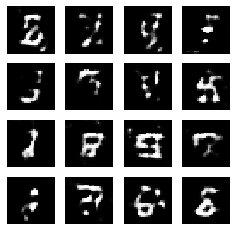

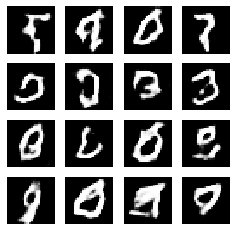

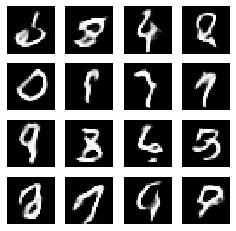

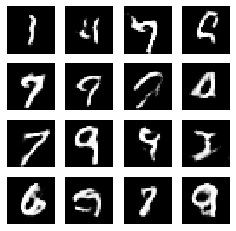

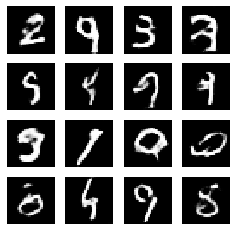

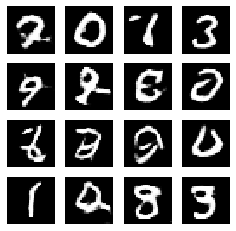

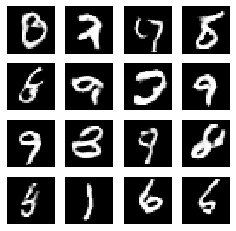

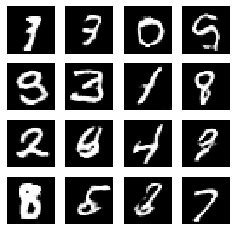

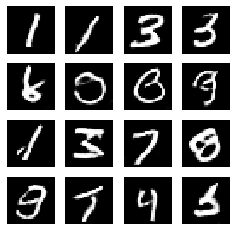

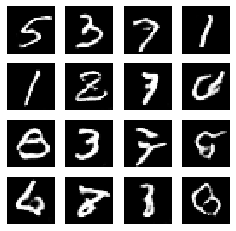

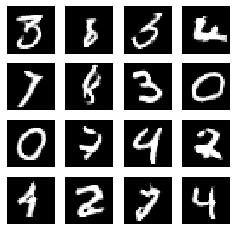

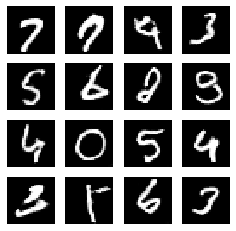

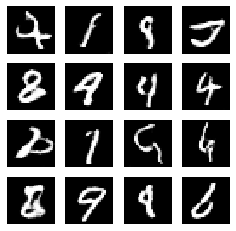

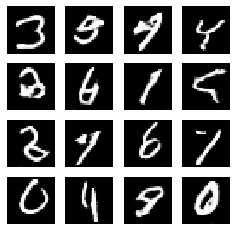

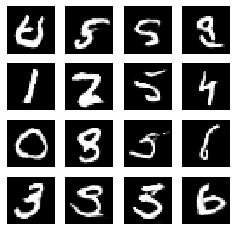

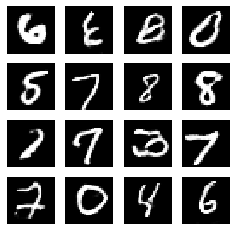

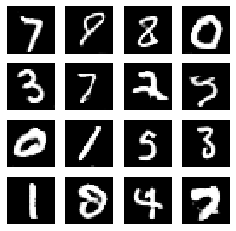

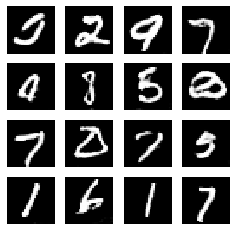

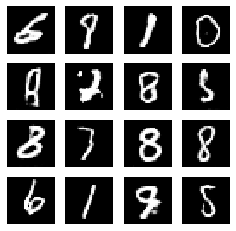

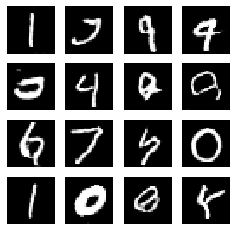

In [10]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

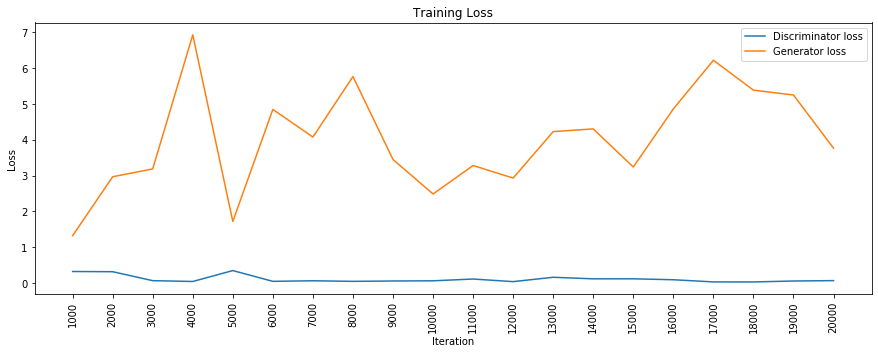

In [11]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoint, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoint, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoint, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

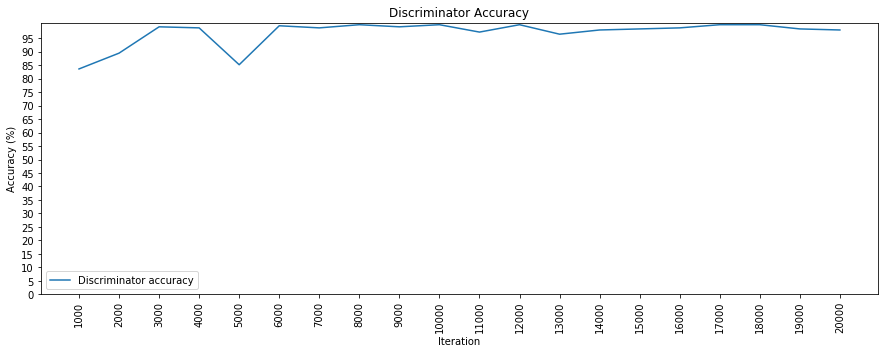

In [12]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoint, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoint, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

DC Gan cause almost no nosie as seen in simple gan